## imports and such

In [25]:
import sys, os
sys.path.append(os.path.realpath(".."))
os.environ["TF_XLA_FLAGS"]="--tf_xla_cpu_global_jit"

import tensorflow as tf
tf.enable_eager_execution()
# tf.enable_v2_behavior()
# sess = tf.InteractiveSession()
# sess.as_default()

import util_funcs
from importlib import reload
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import constants
import clinical_text_analysis as cta
import tsfresh
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from os import path
from addict import Dict
import time

In [26]:
from preprocessingV2 import tfrecord_mappers as tfm
reload(tfm)

<module 'preprocessingV2.tfrecord_mappers' from '/home/ms994/dbmi_eeg_clustering/preprocessingV2/tfrecord_mappers.py'>

In [32]:
train_unbalanced = tfm.get_batched_dataset(["/n/scratch2/ms994/train_4s.tfr"], map_function=tfm.read_tfrecord_autoencoder, batch_size=256,  is_train=True)
valid_data = tfm.get_batched_dataset(["/n/scratch2/ms994/valid_4s.tfr"], map_function=tfm.read_tfrecord_autoencoder,batch_size=256, is_train=False)
test_data = tfm.get_batched_dataset(["/n/scratch2/ms994/test_4s.tfr"], map_function=tfm.read_tfrecord_autoencoder,batch_size=256, is_train=False)

In [36]:
g_noise=1
num_lstm_layers=3
lstm_h=128
cnn2d_n_k=2
num_cnn_layers=3
lr = 0.001

inputLayer = tf.keras.layers.Input((1000,21, 1))
x = inputLayer

x = tf.keras.layers.GaussianNoise(g_noise)(x)
for i in range(num_cnn_layers):
#     x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(cnn2d_n_k**i, (3,3), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D((2,1))(x)
old_x_shape = (x).get_shape().as_list()
x = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]) * int(x.shape[3])), name="LSTM_Reshape")(x)
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(int(lstm_h/2**j), return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.1, l2=0.1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
x_shared = x
for j in range(num_lstm_layers):
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    x = tf.keras.layers.CuDNNLSTM(int(lstm_h/2**(num_lstm_layers-j-1)), return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.1, l2=0.1))(x)
    x = tf.keras.layers.LeakyReLU()(x)
#decoder
x = tf.keras.layers.CuDNNLSTM(old_x_shape[2]*old_x_shape[3], return_sequences=True, name="lstm_decode")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Reshape(old_x_shape[1:], name="reshape_decode")(x)
for i in range(num_cnn_layers):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(cnn2d_n_k**(num_cnn_layers-i-1), (3,3), padding="same")(x)
    x = tf.keras.layers.UpSampling2D((2,1))(x)
    x = tf.keras.layers.LeakyReLU()(x)

x_decode = tf.keras.layers.Reshape((int(x.shape[1]), int(x.shape[2]), int(x.shape[3])), name="decode")(x)

model = tf.keras.Model(inputs=inputLayer, outputs=x_decode)
model.compile(tf.keras.optimizers.Adam(lr=lr),  loss=["logcosh"], metrics=["mean_squared_error"])
batch_size=128
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 1000, 21, 1)       0         
_________________________________________________________________
gaussian_noise_10 (GaussianN (None, 1000, 21, 1)       0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 1000, 21, 1)       10        
_________________________________________________________________
leaky_re_lu_90 (LeakyReLU)   (None, 1000, 21, 1)       0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 500, 21, 1)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 500, 21, 2)        20        
_________________________________________________________________
leaky_re_lu_91 (LeakyReLU)   (None, 500, 21, 2)        0         
__________

In [39]:
modelCheck = tf.keras.callbacks.ModelCheckpoint("/n/scratch2/ms994/cnn_lstm_autoencoder_seizure.h5", save_best_only=True, verbose=1)
earlyStopping = tf.keras.callbacks.EarlyStopping(patience=20)
history = model.fit(train_unbalanced, validation_data=valid_data, steps_per_epoch=500, validation_steps=100, epochs=1000, callbacks=[earlyStopping])

Epoch 1/1000
500/500 [==============================] - 207s 415ms/step - loss: 1275.2931 - mean_squared_error: 96.9757 - val_loss: 3724.1619 - val_mean_squared_error: 13983.6807
Epoch 2/1000
500/500 [==============================] - 208s 415ms/step - loss: 805.4979 - mean_squared_error: 56.4595 - val_loss: 3509.3645 - val_mean_squared_error: 13639.5107
Epoch 3/1000
500/500 [==============================] - 208s 416ms/step - loss: 715.1260 - mean_squared_error: 47.5785 - val_loss: 3112.0522 - val_mean_squared_error: 13555.9209
Epoch 4/1000
500/500 [==============================] - 208s 415ms/step - loss: 682.8908 - mean_squared_error: 44.7801 - val_loss: 2993.9191 - val_mean_squared_error: 13476.2207
Epoch 5/1000
500/500 [==============================] - 208s 415ms/step - loss: 658.8082 - mean_squared_error: 43.2928 - val_loss: 2866.8484 - val_mean_squared_error: 13510.2090
Epoch 6/1000
500/500 [==============================] - 208s 416ms/step - loss: 639.3392 - mean_squared_error

Epoch 30/1000
500/500 [==============================] - 208s 417ms/step - loss: 549.9312 - mean_squared_error: 35.9245 - val_loss: 2603.9209 - val_mean_squared_error: 13406.2637
Epoch 31/1000
500/500 [==============================] - 208s 417ms/step - loss: 549.3433 - mean_squared_error: 35.7771 - val_loss: 2533.3627 - val_mean_squared_error: 13384.6982
Epoch 32/1000
500/500 [==============================] - 208s 416ms/step - loss: 549.0444 - mean_squared_error: 35.8361 - val_loss: 2555.3984 - val_mean_squared_error: 13383.5508
Epoch 33/1000
500/500 [==============================] - 208s 416ms/step - loss: 546.7417 - mean_squared_error: 35.7009 - val_loss: 2576.1504 - val_mean_squared_error: 13302.9824
Epoch 34/1000
500/500 [==============================] - 209s 418ms/step - loss: 546.7233 - mean_squared_error: 35.6053 - val_loss: 2571.7832 - val_mean_squared_error: 13377.5898
Epoch 35/1000
500/500 [==============================] - 209s 417ms/step - loss: 545.0168 - mean_squared_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



500/500 [==============================] - 208s 417ms/step - loss: 538.6374 - mean_squared_error: 34.7219 - val_loss: 2576.2662 - val_mean_squared_error: 13359.9102
Epoch 51/1000
500/500 [==============================] - 208s 416ms/step - loss: 537.5492 - mean_squared_error: 34.7836 - val_loss: 2628.7391 - val_mean_squared_error: 13346.6426


# Show the history graphs

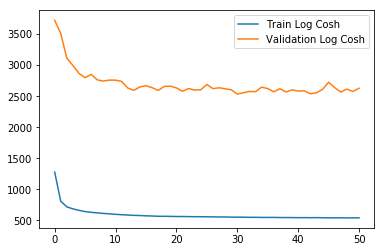

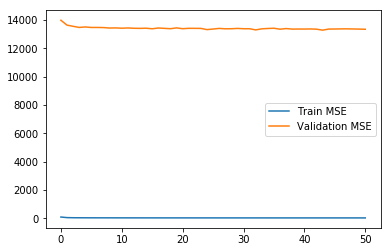

In [68]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Train Log Cosh", "Validation Log Cosh"])
plt.show()
plt.plot(history.history["mean_squared_error"])
plt.plot(history.history["val_mean_squared_error"])
plt.legend(["Train MSE", "Validation MSE"])
plt.show()


# Let's try an example from train set

In [49]:
xData = []
for x in train_unbalanced.take(10).make_one_shot_iterator():
    xData.append(x[0].numpy())

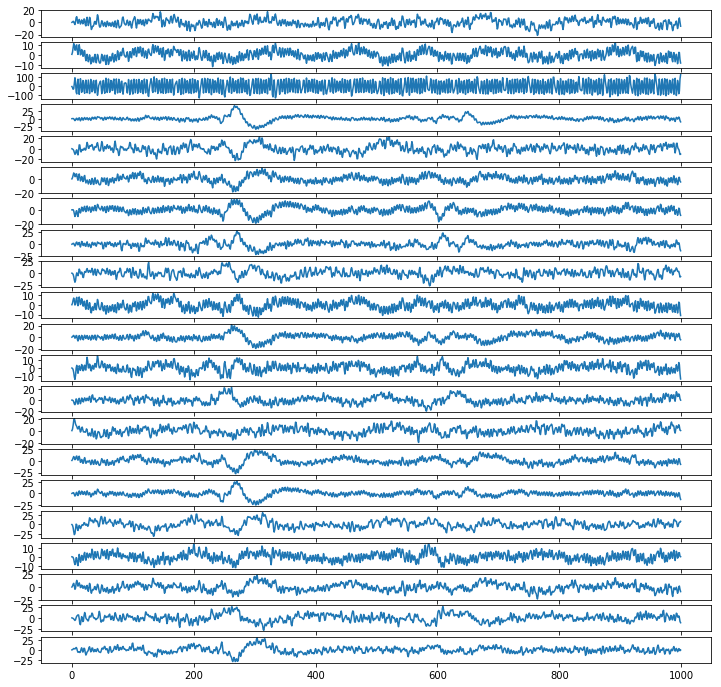

In [65]:
plt.subplots(21,1, figsize=(12,12))
for i in range(21):
    plt.subplot(21,1,i+1)
    plt.plot(xData[0][0].reshape(1000,21).transpose()[i])

In [58]:
predictedX = model.predict(xData[0][0].reshape(1,1000,21,1))

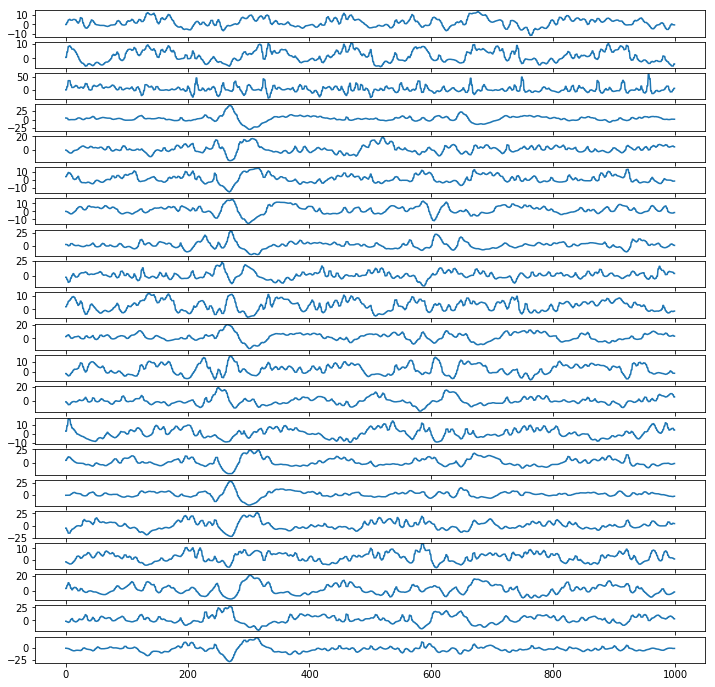

In [67]:
plt.subplots(21,1, figsize=(12,12))
for i in range(21):
    plt.subplot(21,1,i+1)
    plt.plot(predictedX[0].reshape(1000,21).transpose()[i])

# Try to look at validation and testing

In [69]:
xData = []
for x in valid_data.take(10).make_one_shot_iterator():
    xData.append(x[0].numpy())

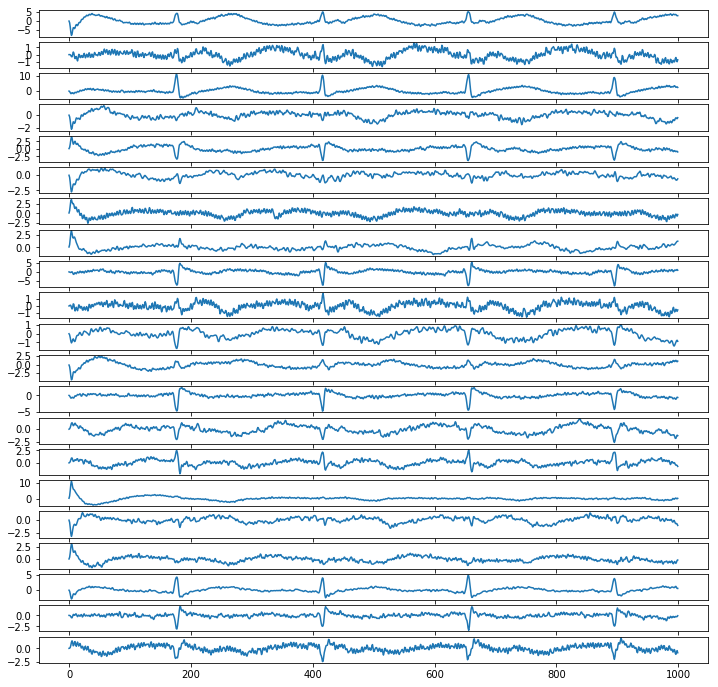

In [70]:
plt.subplots(21,1, figsize=(12,12))
for i in range(21):
    plt.subplot(21,1,i+1)
    plt.plot(xData[0][0].reshape(1000,21).transpose()[i])

In [71]:
predictedX = model.predict(xData[0][0].reshape(1,1000,21,1))

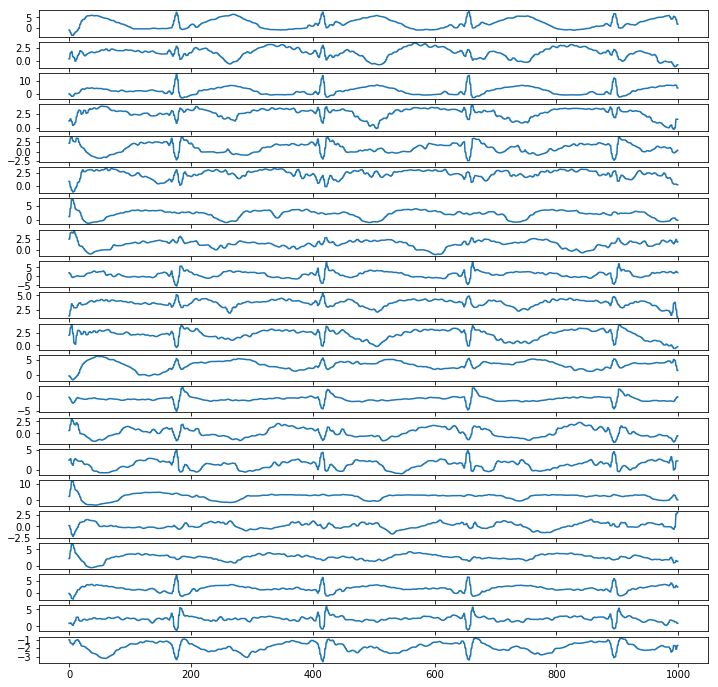

In [72]:
plt.subplots(21,1, figsize=(12,12))
for i in range(21):
    plt.subplot(21,1,i+1)
    plt.plot(predictedX[0].reshape(1000,21).transpose()[i])

In [85]:
# for j in range(10):
def show_for_instance(j):
    plt.subplots(21,2, figsize=(12,12))
    for i in range(21):
        plt.subplot(21,2,2*i+1)
        plt.plot(xData[0][j].reshape(1000,21).transpose()[i])
    predictedX = model.predict(xData[0][j].reshape(1,1000,21,1))
    for i in range(21):
        plt.subplot(21,2,2*i+2)
        plt.plot(predictedX[0].reshape(1000,21).transpose()[i])
    plt.show()

In [ ]:
show_for_instance(1)

In [ ]:
show_for_instance(2)

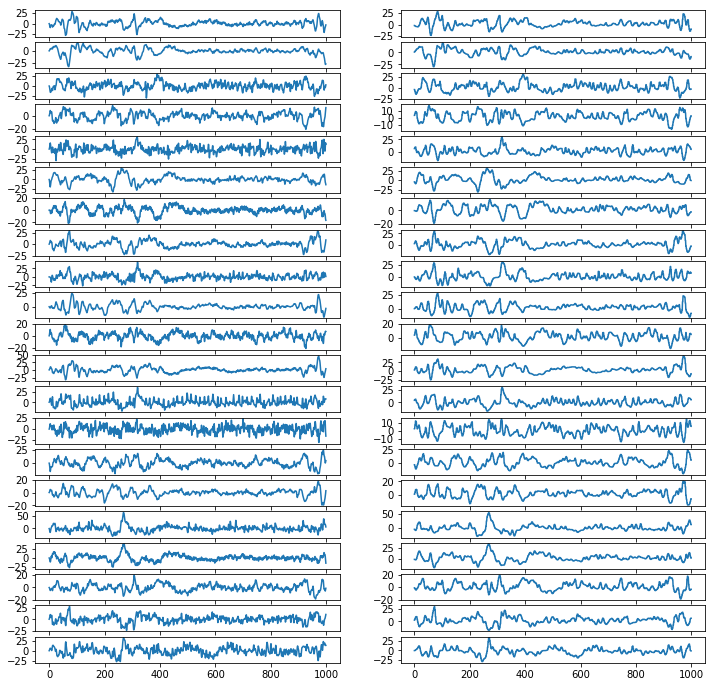

In [87]:
show_for_instance(3)

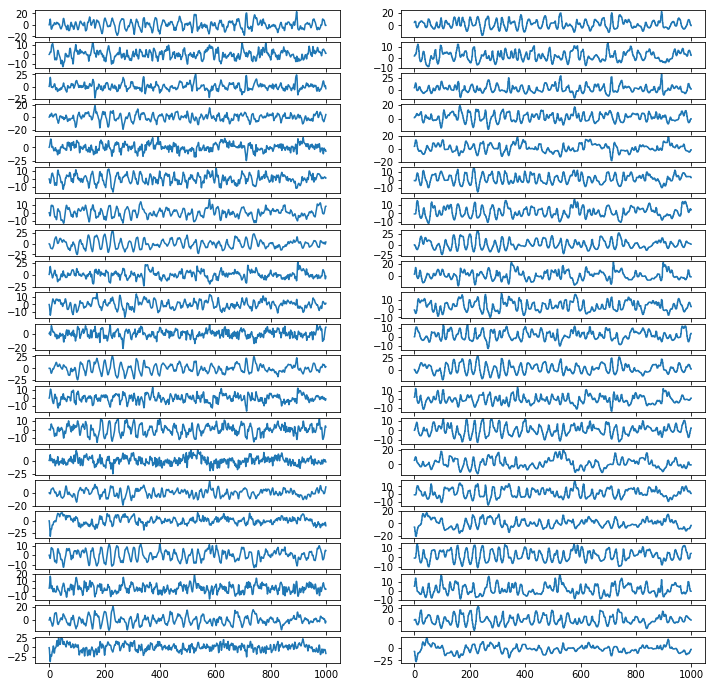

In [86]:
show_for_instance(4)

## test set

In [73]:
xData = []
for x in test_data.take(10).make_one_shot_iterator():
    xData.append(x[0].numpy())

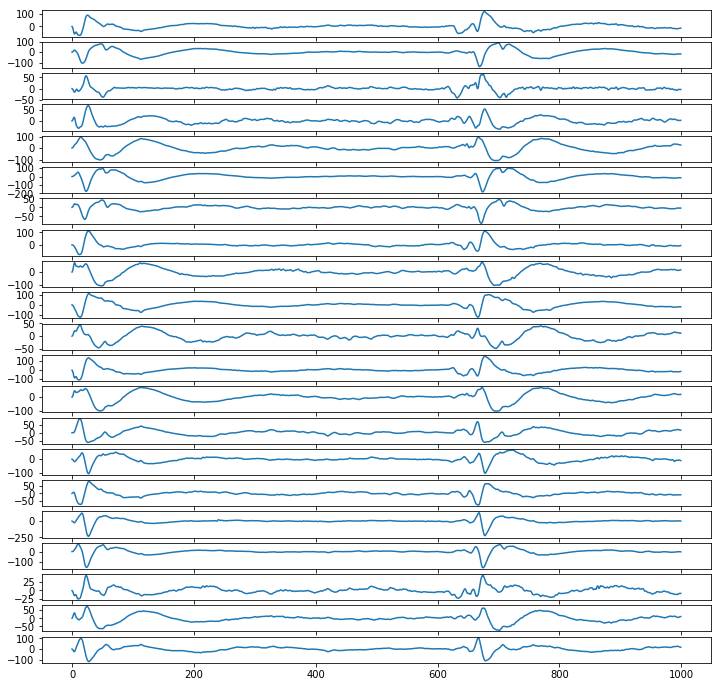

In [74]:
plt.subplots(21,1, figsize=(12,12))
for i in range(21):
    plt.subplot(21,1,i+1)
    plt.plot(xData[0][0].reshape(1000,21).transpose()[i])

In [75]:
predictedX = model.predict(xData[0][0].reshape(1,1000,21,1))

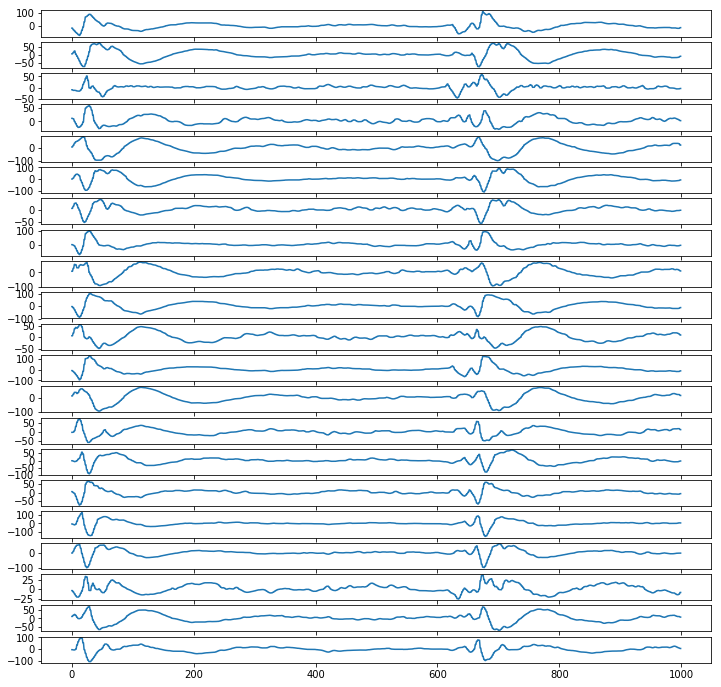

In [76]:
plt.subplots(21,1, figsize=(12,12))
for i in range(21):
    plt.subplot(21,1,i+1)
    plt.plot(predictedX[0].reshape(1000,21).transpose()[i])